In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from sklearn.metrics import classification_report
from tqdm import tnrange, tqdm_notebook
from time import sleep

## Data Preprocessing

### real data

In [2]:
dataset = np.load('dataset_short_time_energy.npy').item()
X = dataset['data'].T # shape = (frames, datasample numbers)
print(X.shape)
m = X.shape[1] # numbers of datasamples
Y = np.array(dataset['target'])
print(Y.shape)
C = len(set(Y)) # number of classes
Y_origin = pd.factorize(Y)[0].astype(np.uint16)

(476, 480)
(480,)


In [3]:
def one_hot_converter(Y, C):
    d = np.eye(C)[Y.reshape(-1)].T
    return d

In [4]:
Y = one_hot_converter(Y_origin, C)
Y.shape

(7, 480)

### randomize X and Y

In [ ]:
# np.random.seed(0)
# permutation = list(np.random.permutation(m))
# shuffled_X = X[:, permutation]
# shuffled_Y = Y[:, permutation].reshape((C, m))

### separate the data to training and test set

In [ ]:
# X_train = shuffled_X[:, :-20]
# X_test = shuffled_X[:, -20:]
# Y_train = shuffled_Y[:, :-20]
# Y_test = shuffled_Y[:, -20:]
# assert X_train.shape[1] == Y_train.shape[1], "train set shape error"
# assert X_test.shape[1] == Y_test.shape[1], "test set shape error"

### without shuffle

In [ ]:
# X_train = X[:, :-20]
# X_test = X[:, -20:]
# Y_train = Y[:, :-20]
# Y_test = Y[:, -20:]
# assert X_train.shape[1] == Y_train.shape[1], "train set shape error"
# assert X_test.shape[1] == Y_test.shape[1], "test set shape error"

### toy data

In [ ]:
# X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
# Y = np.array([[0, 1, 0], [1, 0, 1]])       
# layers_dims = [3, 4, 2]

## Neural Network

### Hyper parameter tuning

In [5]:
parameter_choices = {'hidden_size':[40, 60, 80, 100], 'learning_rate':[7.5e-3, 1e-3, 5e-2]}

In [6]:
def random_parameter_selection():
    return {k:random.choice(v) for k, v in parameter_choices.items()}

In [7]:
params = random_parameter_selection()
type(params['hidden_size'])

int

In [8]:
layers_dims = [X.shape[0], params['hidden_size'], 7] # in this experiment, we always keep one hidden layer
layers_dims

[476, 80, 7]

### initialization

In [58]:
def initialization(layers_dims):
    parameters = {}
    L = len(layers_dims)
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1])*(10**(-2))
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
    return parameters

In [43]:
def he_initialization(layers_dims):
    parameters = {}
    L = len(layers_dims) - 1 # integer representing the number of layers
     
    for l in range(1, L + 1):        
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1])*(np.sqrt(2./layers_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
    return parameters

In [ ]:
parameters = initialization(layers_dims)
print(f'shape of W1: {parameters["W1"].shape}')
print(f'shape of W2: {parameters["W2"].shape}')
print(f'shape of b1: {parameters["b1"].shape}')
print(f'shape of b2: {parameters["b2"].shape}')

### forward propagation

In [75]:
def linear_forward(X, W, b):
    Z = np.dot(W, X) + b
    cache = (X, W, b)
    return Z, cache

In [ ]:
Z1, cache = linear_forward(X, parameters["W1"], parameters["b1"])
dataframe0 = pd.DataFrame(Z1)
# print(dataframe0)
# print(np.isnan(Z1).any()) # check if there is any nan number in Z1

In [11]:
def relu(Z):
    A = np.maximum(0, Z)
    activation_cache = Z
    return A, activation_cache

In [12]:
def sigmoid(Z):
    A = 1 / (np.exp(-1 * Z))
    activation_cache = Z
    return A, activation_cache

In [13]:
def softmax(Z):
#     Z = (Z - np.average(Z))/np.max(Z) 
    Z = Z - np.max(Z, axis=0, keepdims=True)
    A = np.exp(Z)/np.sum(np.exp(Z), axis=0, keepdims=True)
    activation_cache = Z
    return A, activation_cache

In [74]:
def linear_activation_forward(X, W, b, activation):
    Z, cache = linear_forward(X, W, b)
#     print(f"the new Z is {Z- np.max(Z)}")
    if activation == "relu":
        A, activation_cache = relu(Z)
        cache = (cache, activation_cache)
    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
        cache = (cache, activation_cache)
    if activation == "softmax":
        A, activation_cache = softmax(Z)
        cache = (cache, activation_cache)
    return A, cache

In [ ]:
A1, cache1 = linear_activation_forward(X, parameters["W1"], parameters["b1"], activation='relu')
# dataframe1 = pd.DataFrame(A1)
# print(dataframe1)
# print(np.isnan(A1).any())
# print(f"A1 is {A1}")
# print(f"X is {cache1[0][0]}")
# print(f"W1 is {cache1[0][1]}")
# print(f"b1 is {cache1[0][2]}")
# print(f"Z1 is {cache1[1]}")
A2, cache2 = linear_activation_forward(A1, parameters["W2"], parameters["b2"], activation='softmax')
# dataframe2 = pd.DataFrame(A2)
# print(dataframe2)
# print(np.isnan(A2).any())
# print(np.where(np.isnan(A2)))
# print(f"A2 is{A2}")
# print(f"A1 is {cache2[0][0]}")
# print(f"W2 is {cache2[0][1]}")
# print(f"b2 is {cache2[0][2]}")
# print(f"Z2 is {cache2[1]}")

In [73]:
def forward_prop(X, parameters):
    L = len(parameters)//2
    A = X
    caches = []
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" +str(l)], activation="relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" +str(L)], activation="softmax")
    caches.append(cache)
    return AL, caches

In [ ]:
AL, caches = forward_prop(X, parameters)
dataframeL = pd.DataFrame(AL)
print(dataframeL)
print(np.isnan(AL).any())
print(f'A2 is {AL}')
print(f'X is {caches[0][0][0]}')
print(f'W1 is {caches[0][0][1]}')
print(f"b1 is {caches[0][0][2]}")
print(f"Z1 is {caches[0][1]}")

print(f"A1 is {caches[1][0][0]}")
print(f"W2 is {caches[1][0][1]}")
print(f"b2 is {caches[1][0][2]}")
print(f"Z2 is {caches[1][1]}")

### cost

In [79]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1/m)*np.sum(Y*np.log(AL))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [ ]:
compute_cost(AL, Y)

### back propagation

In [80]:
def linear_backwards(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
  
     
    dW = 1/m * np.dot(dZ,A_prev.T)
    db = 1/m * np.sum(dZ,axis=1,keepdims=True)
    dA_prev = np.dot(W.T,dZ)
   

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    return dA_prev, dW, db

In [ ]:
dZ2 = A2 - Y
grads = {}
dA2, dW2, db2 = linear_backwards(dZ2, cache2[0])
# print(f'dZ2 is {dZ2}')
# print(f'dA2 is {dA2}')
# print(f'dW2 is {dW2}')
# print(f'db2 is {db2}')

grads['dA2'] = dA2
grads['dW2'] = dW2
grads['db2'] = db2


In [81]:
def relu_backward(dA, cache):    
    Z = cache
    dZ = np.array(dA, copy=True)
 
    dZ[Z <= 0] = 0

    assert (dZ.shape == Z.shape)

    return dZ

In [ ]:
dZ1 = relu_backward(dA2, cache1[1])
dZ1 

dA1, dW1, db1 = linear_backwards(dZ1, cache1[0])

# print(f'dZ1 is {dZ1}')
# print(f'dA1 is {dA1}')
# print(f'dW1 is {dW1}')
# print(f'db1 is {db1}')

grads['dA1'] = dA1
grads['dW1'] = dW1
grads['db1'] = db1

In [82]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        
        dZ = relu_backward(dA, activation_cache)
       
        
    elif activation == "sigmoid":
        
        dZ = sigmoid_backward(dA, activation_cache)
     
    
    # Shorten the code
    dA_prev, dW, db = linear_backwards(dZ, linear_cache)
    
    return dA_prev, dW, db

In [83]:
def back_prop(AL, Y, cache):
    grads = {}
    L = len(cache)
#     print(L)
    m = Y.shape[1]
    current_cache = cache[-1]
    dZL = AL - Y #gradient back to the layer before softmax
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backwards(dZL, current_cache[0]) #gradient of the last linear layer
    
    for l in reversed(range(L-1)):
        current_cache = cache[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" +str(L)], current_cache, 'relu')
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [ ]:
grads = back_prop(AL, Y, caches)
grads['db1'].shape

### update parameters

In [84]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
#     print(parameters['b1'].shape)
#     print(grads['db1'].shape)
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters

In [ ]:
parameters = update_parameters(initialization(layers_dims) , grads, 0.0075)
parameters["b1"]

### two layer model

In [ ]:
def two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False):
    costs = []
    grads = {}
    parameters = initialization(layers_dims)
#     print(parameters)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    for i in range(num_iterations):
        
        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "softmax")
        
#         print(cache1)
        
        cost = compute_cost(A2, Y)
        
        dZL = A2 - Y
        dA2, dW2, db2 = linear_backwards(dZL, cache2[0])
        dA1, dW1, db1 = linear_activation_backward(dA2, cache1, 'relu')
        
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        parameters = update_parameters(parameters, grads, learning_rate)
#         print(parameters)
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [ ]:
parameters = two_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=True)

In [ ]:
parameters = initialization(layers_dims)
W1 = parameters["W1"]
b1 = parameters["b1"]
W2 = parameters["W2"]
b2 = parameters["b2"]
for i in range(20):
    A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
    print(A1)

In [64]:
def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False): #lr was 0.009
    np.random.seed(1)
    costs = []                      
    
#     parameters = initialization(layers_dims)
    parameters = he_initialization(layers_dims)
    
    for i in range(0, num_iterations):
        
        AL, caches = forward_prop(X, parameters)     
        cost = compute_cost(AL, Y)       
            
        grads = back_prop(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" % (i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    if print_cost:
        plt.plot(np.squeeze(costs), "o")
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

In [77]:
 parameters = L_layer_model(X_train, Y_train, layers_dims, learning_rate=params['learning_rate'], num_iterations=3000, print_cost=True)

NameError: name 'X_train' is not defined

In [62]:
def predict(parameters, X):
    AL, caches = forward_prop(X, parameters)
    prediction = np.argmax(AL, axis=0)
    return prediction

In [63]:
predictions_X_train = predict(parameters, X_train)
print(predictions_X_train)
print(np.argmax(Y_train, axis=0))
assert len(predictions_X_train) == Y_train.shape[1], "length of {}"
predictions_X_test = predict(parameters, X_test)
print(predictions_X_test)
print(np.argmax(Y_test, axis=0))
assert len(predictions_X_test) == Y_test.shape[1], "length of {}"

NameError: name 'parameters' is not defined

In [24]:
def accuracy(predictions, Y):
    count = 0
    for i in zip(predictions, Y):
        if i[0] == i[1]:
            count += 1
    accuracy = count /len(predictions)
    return accuracy

In [ ]:
accuracy_train = accuracy(predictions_X_train, np.argmax(Y_train, axis=0))
accuracy_train

In [ ]:
accuracy_test = accuracy(predictions_X_test, np.argmax(Y_test, axis=0))
accuracy_test

In [40]:
import os
import json
from datetime import datetime

In [ ]:
def save_results_to_file(exp_num):
    for i in range(exp_num):
        params = random_parameter_selection()
        layers_dims = [X.shape[0], params['hidden_size'], 7]
        parameters = L_layer_model(X_train, Y_train, layers_dims, learning_rate=params['learning_rate'], num_iterations=3000, print_cost=False)
        accuracy_test = accuracy(predict(parameters, X_test), np.argmax(Y_test, axis=0))

        experiment_dir = os.path.abspath("./experiments/{}_accuracy_{}".format(datetime.now().strftime('%Y%m%d_%H%M%S_%f'),accuracy_test))
        if not os.path.exists(experiment_dir):
            os.makedirs(experiment_dir)

        parameter_data_file = os.path.join(experiment_dir, "parameter.json")

        with open(parameter_data_file, 'w') as f:
            json.dump(params, f)

In [ ]:
exp_num = 2
save_results_to_file(exp_num)

### Hyperparameter tuning with cross validation

In [67]:
from sklearn.model_selection import KFold
X = X.T
y = Y.T
print(X.shape, y.shape)
kf = KFold(n_splits=9, shuffle=True, random_state=0)

(480, 476) (480, 7)


In [68]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [69]:
from sklearn.metrics import f1_score

In [70]:
def save_results_to_file_with_ht_and_cv(exp_num):
    best_f1_score = 0
    for i in tnrange(exp_num, desc='1st loop'):
        params = random_parameter_selection()
        layers_dims = [476, params['hidden_size'], 7]
        
#         accuracy_train = []
#         accuracy_val = []
        f1_score_val = []
        
        # cross validataion with KFold n_splits
        for train_index, val_index in kf.split(X_trainval):
            X_train, X_val = X[train_index].T, X[val_index].T
            y_train, y_val = y[train_index].T, y[val_index].T
#             print(f'X_train: {X_train.shape},\nX_test: {X_test.shape},\ny_train: {y_train.shape},\ny_test:{y_test.shape}')
            
            parameters = L_layer_model(X_train, y_train, layers_dims, learning_rate=params['learning_rate'], num_iterations=3000, print_cost=False)
            prediction_X_train = predict(parameters, X_train)
            prediction_X_val = predict(parameters, X_val)
#             accuracy_train.append(accuracy(prediction_X_train, np.argmax(y_train, axis=0)))
#             accuracy_val.append(accuracy(prediction_X_val, np.argmax(y_val, axis=0)))
            f1_score_val.append(f1_score(np.argmax(y_val, axis=0), prediction_X_val, average='micro'))
    
#         accuracy_train_mean = np.array(accuracy_train).mean()
#         accuracy_val_mean = np.array(accuracy_val).mean()  
        f1_score_val_mean = np.array(f1_score_val).mean()
        
        if f1_score_val_mean > best_f1_score:
            best_f1_score = f1_score_val_mean
            best_params = params
        
#         experiment_dir = os.path.abspath("./experiments/{}_accuracy_{}".format(datetime.now().strftime('%Y%m%d_%H%M%S_%f'),accuracy_val_mean))
        experiment_dir = os.path.abspath("./experiments/{}_f1_score_{:.3f}".format(datetime.now().strftime('%Y%m%d_%H%M%S_%f'), f1_score_val_mean))

        if not os.path.exists(experiment_dir):
                os.makedirs(experiment_dir)

        parameter_data_file = os.path.join(experiment_dir, "parameter.json")

        with open(parameter_data_file, 'w') as f:
            json.dump(params, f)
    return best_f1_score, best_params

In [71]:
exp_num = 50
best_f1_score, best_params = save_results_to_file_with_ht_and_cv(exp_num)

HBox(children=(IntProgress(value=0, description='1st loop', max=50), HTML(value='')))

c:\anaconda3\envs\speechrecognition\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
c:\anaconda3\envs\speechrecognition\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


Cost after iteration 0: 28.153707
Cost after iteration 100: 1.148794
Cost after iteration 200: 1.019735
Cost after iteration 300: 0.937108
Cost after iteration 400: 0.862373
Cost after iteration 500: 0.803661
Cost after iteration 600: 0.770679
Cost after iteration 700: 0.723783
Cost after iteration 800: 0.699065
Cost after iteration 900: 0.675898
Cost after iteration 1000: 0.658769
Cost after iteration 1100: 0.639122
Cost after iteration 1200: 0.623110
Cost after iteration 1300: 0.604667
Cost after iteration 1400: 0.592553
Cost after iteration 1500: 0.575945
Cost after iteration 1600: 0.563464
Cost after iteration 1700: 0.549203
Cost after iteration 1800: 0.540747
Cost after iteration 1900: 0.534534
Cost after iteration 2000: 0.523951
Cost after iteration 2100: 0.518198
Cost after iteration 2200: 0.512161
Cost after iteration 2300: 0.506276
Cost after iteration 2400: 0.496368
Cost after iteration 2500: 0.492518
Cost after iteration 2600: 0.489064
Cost after iteration 2700: 0.485922
Cos

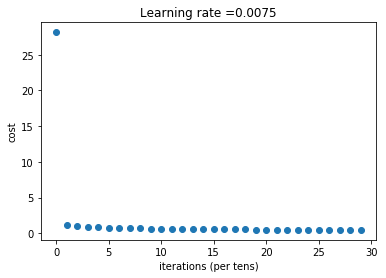

In [85]:
best_weights_bias = L_layer_model(X_trainval.T, y_trainval.T, [476, best_params['hidden_size'], 7], learning_rate=best_params['learning_rate'], num_iterations=3000, print_cost=True)

In [91]:
predict_X_test = predict(best_weights_bias, X_test.T)

(48, 476)

In [93]:
y_test = y_test.T

(7, 48)

In [89]:
print("Micro average f1 score: {:.3f}".format(f1_score(np.argmax(y_test, axis=0), predict_X_test, average='micro')))
print("Macro average f1 score: {:.3f}".format(f1_score(y_test, predict_X_test, average="macro")))

Micro average f1 score: 0.312


ValueError: Found input variables with inconsistent numbers of samples: [7, 48]

In [90]:
print(classification_report(np.argmax(y_test, axis=0), predict_X_test))

c:\anaconda3\envs\speechrecognition\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         3
          1       0.00      0.00      0.00         6
          2       0.00      0.00      0.00         8
          3       0.50      0.20      0.29         5
          4       0.39      0.80      0.52        15
          5       0.20      0.17      0.18         6
          6       0.50      0.20      0.29         5

avg / total       0.25      0.31      0.25        48

